In [1]:
import pandas as pd
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
from utils import * 
import xarray

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
# todos: test on same site, different time. log-normalize ssrd and handle nans in tcc

2022-11-14 20:59:03.377553: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
cwd = os.getcwd()
train_path = "data/train/"
test_path = "data/test/"

# Training set
train_files    = ["mantua"]
X_train_xr, _  = prepare_predictor(train_files,train_path)
y_train_xr, _  = prepare_predictand(train_files,train_path)

# Test set
X_test_xr, _ = prepare_predictor('water', data_path=test_path,time_reindex=False)
y_test_xr, _ = prepare_predictand('water',data_path=test_path,time_reindex=False)

In [3]:
y_train_xr

<xarray.Dataset>
Dimensions:                 (time: 11198, latitude: 1, longitude: 1)
Coordinates:
  * time                    (time) int64 0 1 2 3 4 ... 11194 11195 11196 11197
  * latitude                (latitude) float64 39.77
  * longitude               (longitude) float64 -75.14
Data variables:
    ambientTemperature      (time, latitude, longitude) float64 -9.542 ... 71.43
    moduleTemperature       (time, latitude, longitude) float64 30.95 ... 69.67
    planeOfArrayIrradiance  (time, latitude, longitude) float64 540.3 ... 3.574

In [ ]:
do it as preprocessing - take distance based on closest pixel, take the average of the 4, euclidean distance to weight the values

use a graph, on the edge have the distance to neighbor, not a convulation, adapative to distance

try to get it to pull from a neighbor. 

notebook for geospatial weighting - 

StEp: 
    
    @Carlcarrie



In [4]:
X_train_xr

<xarray.Dataset>
Dimensions:    (longitude: 13, latitude: 13, time: 11198)
Coordinates:
  * longitude  (longitude) float32 39.27 39.37 39.47 39.52 ... 40.07 40.17 40.27
  * latitude   (latitude) float32 -75.64 -75.54 -75.44 ... -74.84 -74.74 -74.64
  * time       (time) int64 0 1 2 3 4 5 ... 11192 11193 11194 11195 11196 11197
    expver     int32 ...
Data variables:
    ssrd       (time, latitude, longitude) float32 2.47e+05 2.476e+05 ... 2.0
    tcc        (time, latitude, longitude) float32 1.0 nan nan ... nan nan nan
Attributes:
    Conventions:  CF-1.6
    history:      2022-10-24 22:06:24 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [19]:
X_train_xr.values

<bound method Mapping.values of <xarray.Dataset>
Dimensions:    (longitude: 13, latitude: 13, time: 11198)
Coordinates:
  * longitude  (longitude) float32 39.27 39.37 39.47 39.52 ... 40.07 40.17 40.27
  * latitude   (latitude) float32 -75.64 -75.54 -75.44 ... -74.84 -74.74 -74.64
  * time       (time) int64 0 1 2 3 4 5 ... 11192 11193 11194 11195 11196 11197
    expver     int32 5
Data variables:
    ssrd       (time, latitude, longitude) float32 2.47e+05 2.476e+05 ... 2.0
    tcc        (time, latitude, longitude) float32 1.0 nan nan ... nan nan nan
Attributes:
    Conventions:  CF-1.6
    history:      2022-10-24 22:06:24 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...>

In [5]:
X_train_df = pd.DataFrame({
                            "ssrd": X_train_xr["ssrd"].stack(dim=["latitude", "longitude"]),
                            "tcc": X_train_xr["tcc"].stack(dim=["latitude", "longitude"])
                          }, index=X_train_xr["tcc"].coords)

ValueError: Data must be 1-dimensional

In [6]:
pd.DataFrame((X_train_xr["tcc"].stack(dim=["latitude", "longitude","time"]).to_pandas()))

0
latitude   longitude time           
-75.641998 39.265999 0      1.000008
                     1      1.000008
                     2      1.000008
                     3      1.000008
                     4      1.000008
...                              ...
-74.641998 40.266998 11193       NaN
                     11194       NaN
                     11195       NaN
                     11196       NaN
                     11197       NaN

[1892462 rows x 1 columns]

In [7]:
pd.DataFrame((X_train_xr["tcc"].stack(dim=["latitude", "longitude"]).to_pandas()))

latitude  -75.641998                                                    \
longitude  39.265999 39.366100 39.466202 39.516251 39.566299 39.666401   
time                                                                     
0           1.000008       NaN       NaN  1.000008       NaN       NaN   
1           1.000008       NaN       NaN  1.000008       NaN       NaN   
2           1.000008       NaN       NaN  1.000008       NaN       NaN   
3           1.000008       NaN       NaN  1.000008       NaN       NaN   
4           1.000008       NaN       NaN  1.000008       NaN       NaN   
...              ...       ...       ...       ...       ...       ...   
11193            NaN       NaN       NaN       NaN       NaN       NaN   
11194            NaN       NaN       NaN       NaN       NaN       NaN   
11195            NaN       NaN       NaN       NaN       NaN       NaN   
11196            NaN       NaN       NaN       NaN       NaN       NaN   
11197            NaN       NaN       NaN       NaN       NaN       NaN   

latitude                                           ... -74.641998            \
longitude 39.766499 39.866600 39.966702 40.016750  ...  39.516251 39.566299   
time                                               ...                        
0          1.000008       NaN       NaN  1.000008  ...   1.000008       NaN   
1          1.000008       NaN       NaN  1.000008  ...   1.000008       NaN   
2          1.000008       NaN       NaN  0.999687  ...   1.000008       NaN   
3          1.000008       NaN       NaN  1.000008  ...   1.000008       NaN   
4          1.000008       NaN       NaN  1.000008  ...   1.000008       NaN   
...             ...       ...       ...       ...  ...        ...       ...   
11193           NaN       NaN       NaN       NaN  ...        NaN       NaN   
11194           NaN       NaN       NaN       NaN  ...        NaN       NaN   
11195           NaN       NaN       NaN       NaN  ...        NaN       NaN   
11196           NaN       NaN       NaN       NaN  ...        NaN       NaN   
11197           NaN       NaN       NaN       NaN  ...        NaN       NaN   

latitude                                                               \
longitude 39.666401 39.766499 39.866600 39.966702 40.016750 40.066799   
time                                                                    
0               NaN  1.000008       NaN       NaN  1.000008       NaN   
1               NaN  1.000008       NaN       NaN  1.000008       NaN   
2               NaN  1.000008       NaN       NaN  1.000008       NaN   
3               NaN  1.000008       NaN       NaN  1.000008       NaN   
4               NaN  1.000008       NaN       NaN  1.000008       NaN   
...             ...       ...       ...       ...       ...       ...   
11193           NaN       NaN       NaN       NaN       NaN       NaN   
11194           NaN       NaN       NaN       NaN       NaN       NaN   
11195           NaN       NaN       NaN       NaN       NaN       NaN   
11196           NaN       NaN       NaN       NaN       NaN       NaN   
11197           NaN       NaN       NaN       NaN       NaN       NaN   

latitude                       
longitude 40.166901 40.266998  
time                           
0               NaN  1.000008  
1               NaN  1.000008  
2               NaN  1.000008  
3               NaN  1.000008  
4               NaN  1.000008  
...             ...       ...  
11193           NaN       NaN  
11194           NaN       NaN  
11195           NaN       NaN  
11196           NaN       NaN  
11197           NaN       NaN  

[11198 rows x 169 columns]

In [57]:
X_train_df = pd.DataFrame({
                            "ssrd": X_train_xr["ssrd"].stack(dim=["latitude", "longitude"]),
                            "tcc": pd.DataFrame((X_train_xr["tcc"].stack(dim=["latitude", "longitude"]).to_pandas()))
                          }, index=X_train_xr["ssrd"].coords['time'].data)

ValueError: Data must be 1-dimensional

In [6]:
X_train_df = X_train_xr["ssrd"].stack(dim=["latitude", "longitude"])
X_train_df = pd.DataFrame({"ssrd": X_train_xr["ssrd"].data,
                           "tcc": X_train_xr["tcc"].data
                          }, index=X_train_xr["ssrd"].coords['time'].data)


X_test_df = X_test_xr["ssrd"].stack(dim=["latitude", "longitude"])



y_train_df = y_train_xr["planeOfArrayIrradiance"].stack(dim=["latitude", "longitude"]).fillna(0)
y_train_df = pd.DataFrame(y_train_df.to_pandas())
y_test_df = y_test_xr["planeOfArrayIrradiance"].stack(dim=["latitude", "longitude"]).fillna(0)


In [12]:
X_train_df

<xarray.DataArray 'ssrd' (time: 11198, dim: 169)>
array([[-0.58294934, -0.5828869 , -0.58282465, ..., -0.5672447 ,
        -0.56718224, -0.56712   ],
       [-0.57478535, -0.57478535, -0.5747231 , ..., -0.5544067 ,
        -0.5543445 , -0.5543445 ],
       [-0.5732897 , -0.5732897 , -0.5732897 , ..., -0.5504183 ,
        -0.5504183 , -0.55048054],
       ...,
       [-0.6077526 , -0.6077526 , -0.6077526 , ..., -0.6077526 ,
        -0.6077526 , -0.6077526 ],
       [-0.6077526 , -0.6077526 , -0.6077526 , ..., -0.6077526 ,
        -0.6077526 , -0.6077526 ],
       [-0.6077526 , -0.6077526 , -0.6077526 , ..., -0.6077526 ,
        -0.6077526 , -0.6077526 ]], dtype=float32)
Coordinates:
  * time       (time) int64 0 1 2 3 4 5 ... 11192 11193 11194 11195 11196 11197
    expver     int32 5
  * dim        (dim) object MultiIndex
  * latitude   (dim) float32 -75.64 -75.64 -75.64 ... -74.64 -74.64 -74.64
  * longitude  (dim) float32 39.27 39.37 39.47 39.52 ... 40.02 40.07 40.17 40.27

In [7]:
# Standardization
mean, std = X_train_df.mean(), X_train_df.std()

X_train_df   = (X_train_df - mean)/std
X_test_df    = (X_test_df - mean)/std

X_train = X_train_df.to_numpy()
y_train = y_train_df.to_numpy()
X_test = X_test_df.to_numpy()
Y_test = y_test_df.to_numpy()

print(X_train.shape,y_train.shape)
print(X_test.shape,y_train.shape)


(11198, 169) (11198, 1)
(11198, 169) (11198, 1)


In [10]:
# set hyperparameters
n_neuron       = 512
activation     = 'relu'
num_epochs     = 48
learning_rate  = 0.001
minibatch_size = 64
model_num      = 1

#create the model
model = Sequential()

model.add(Dense(n_neuron,  activation=activation,input_shape=(X_train.shape[1],))) #  the 1st hidden layer 
model.add(Dense(n_neuron,  activation=activation)) # the 2nd hidden layer
model.add(Dense(n_neuron,  activation=activation)) # the 3rd hidden layer
model.add(Dense(y_train.shape[1],  activation='linear')) # the output layer

model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               87040     
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 dense_3 (Dense)             (None, 1)                 513       
                                                                 
Total params: 612,865
Trainable params: 612,865
Non-trainable params: 0
_________________________________________________________________


2022-10-28 13:03:40.303460: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)


history = model.fit(X_train, y_train, 
                    batch_size      = minibatch_size,
                    epochs          = num_epochs,
                    validation_split= 0.5, 
                    verbose         = 1,
                    callbacks       = [early_stop])



Epoch 1/48
88/88 [==============================] - 1s 6ms/step - loss: nan - val_loss: nan
Epoch 2/48
88/88 [==============================] - 0s 5ms/step - loss: nan - val_loss: nan
Epoch 3/48
88/88 [==============================] - 0s 5ms/step - loss: nan - val_loss: nan
Epoch 4/48
88/88 [==============================] - 0s 5ms/step - loss: nan - val_loss: nan
Epoch 5/48
88/88 [==============================] - 0s 5ms/step - loss: nan - val_loss: nan
Epoch 6/48
88/88 [==============================] - 0s 5ms/step - loss: nan - val_loss: nan
Epoch 7/48
88/88 [==============================] - 0s 5ms/step - loss: nan - val_loss: nan
Epoch 8/48
88/88 [==============================] - 0s 5ms/step - loss: nan - val_loss: nan
Epoch 9/48
88/88 [==============================] - 0s 5ms/step - loss: nan - val_loss: nan
Epoch 10/48
88/88 [==============================] - 0s 5ms/step - loss: nan - val_loss: nan
Epoch 11/48
88/88 [==============================] - 0s 5ms/step - loss: nan - 

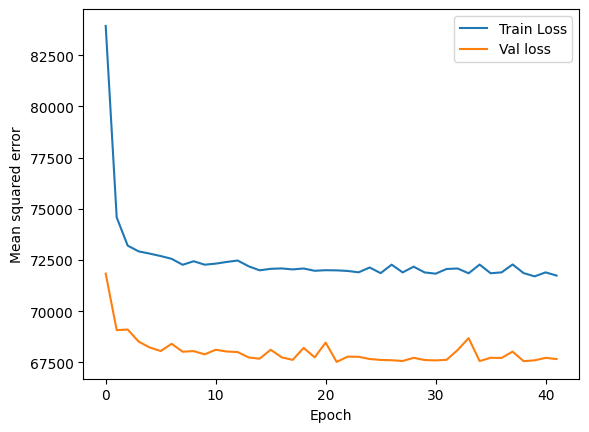

In [43]:
plot_history(history)

In [44]:
model_path = os.path.join(cwd,'saved_model')
make_dir(model_path)

In [45]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save(os.path.join(model_path,'NN_model.h5'))

In [46]:
# reload the saved model
model = load_model(os.path.join(model_path,'NN_model.h5'))

In [47]:
coords_mantua = {'lon' : 39.766038926962466, 'lat' : -75.14202657295235}
coords_west = {'lon' : 41.13935584322975, 'lat' : -73.52551929903115}
coords_water = {'lon' : 39.75493159954764, 'lat' : -74.88289845779185}

In [50]:
X_test

array([[-0.57123077, -0.5711687 , -0.57272017, -0.5726581 ],
       [-0.55937725, -0.55931526, -0.5613632 , -0.5613012 ],
       [-0.5560262 , -0.5560262 , -0.5583224 , -0.5583224 ],
       ...,
       [-0.6075358 , -0.6075358 , -0.6075358 , -0.6075358 ],
       [-0.6075358 , -0.6075358 , -0.6075358 , -0.6075358 ],
       [-0.6075358 , -0.6075358 , -0.6075358 , -0.6075358 ]],
      dtype=float32)

In [49]:
y_test_pre = model.predict(X_test)

ValueError: in user code:

    File "/Users/alattar/opt/anaconda3/envs/EEE/lib/python3.9/site-packages/keras/engine/training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "/Users/alattar/opt/anaconda3/envs/EEE/lib/python3.9/site-packages/keras/engine/training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/alattar/opt/anaconda3/envs/EEE/lib/python3.9/site-packages/keras/engine/training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "/Users/alattar/opt/anaconda3/envs/EEE/lib/python3.9/site-packages/keras/engine/training.py", line 1983, in predict_step
        return self(x, training=False)
    File "/Users/alattar/opt/anaconda3/envs/EEE/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/alattar/opt/anaconda3/envs/EEE/lib/python3.9/site-packages/keras/engine/input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1" is incompatible with the layer: expected shape=(None, 6), found shape=(None, 4)


In [ ]:
df_test = pd.DataFrame(y_test_xr["directIrradiance"].stack(dim=["latitude", "longitude"]),columns=["y_actual"],index=X_test_xr["time"])
df_test["y_predict"] = y_test_pre
df_test

In [27]:
df_test[50:100]

NameError: name 'df_test' is not defined